## Set up Workspace

### Steps

1. Read in data
2. Regrid to 0.25 deg Lat-Lon grid
3. Align time
4. Bias Correct
5. Awaiting comparison to code in R

In [1]:
from dask.distributed import Client
client = Client()

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy import interpolate, stats
import xesmf as xe
import pandas as pd
from calendar import isleap
from dateutil import relativedelta as rd
from datetime import datetime, timedelta
import cftime
import intake
import yaml
import pandas as pd
from intake_esm import config
from distributed.utils import format_bytes

/glade/u/home/jkent/miniconda3/envs/pangeo/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
import sys
print(sys.executable)

/glade/u/home/jkent/miniconda3/envs/pangeo/bin/python


In [4]:
%matplotlib inline

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

## Look at Data

In [5]:
config.get('collections.cordex')

test = yaml.safe_load('''name: NA-CORDEX
collection_type: cordex
data_sources:
  CORDEX-Data:
    locations:
      - name: GLADE
        loc_type: posix
        direct_access: True
        urlpath: /glade/collections/cdg/data/cordex/data/''')        

col = intake.open_esm_metadatastore(collection_input_definition=test, overwrite_existing=True)

Getting file listing: CORDEX-Data:GLADE:posix:/glade/collections/cdg/data/cordex/data/



<class 'pandas.core.frame.DataFrame'>
Int64Index: 17166 entries, 14399 to 11851
Data columns (total 13 columns):
resource                  17166 non-null object
resource_type             17166 non-null object
direct_access             17166 non-null bool
variable                  17166 non-null object
experiment                17166 non-null object
global_climate_model      17166 non-null object
regional_climate_model    17166 non-null object
frequency                 17166 non-null object
grid                      17166 non-null object
bias_corrected_or_raw     17166 non-null object
file_fullpath             17166 non-null object
file_basename             17166 non-null object
file_dirname              17166 non-null object
dtypes: bool(1), object(12)
memory usage: 1.7+ MB
None
Persisting NA-CORDEX at : /glade/u/home/jkent/.intake_esm/collections/cordex/NA-CORDEX.cordex.csv


In [6]:
query = col.search(variable='uas', global_climate_model = 'CanESM2', experiment = ['hist', 'rcp85'], regional_climate_model = 'CRCM5-UQAM', frequency = 'day', grid = 'NAM-44i', bias_corrected_or_raw = 'raw')
query.query_results.head()

,resource,resource_type,direct_access,variable,experiment,global_climate_model,regional_climate_model,frequency,grid,bias_corrected_or_raw,file_fullpath,file_basename,file_dirname
10661,CORDEX-Data:GLADE:posix:/glade/collections/cdg...,posix,True,uas,hist,CanESM2,CRCM5-UQAM,day,NAM-44i,raw,/glade/collections/cdg/data/cordex/data/raw/NA...,uas.hist.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.nc,/glade/collections/cdg/data/cordex/data/raw/NA...
10676,CORDEX-Data:GLADE:posix:/glade/collections/cdg...,posix,True,uas,rcp85,CanESM2,CRCM5-UQAM,day,NAM-44i,raw,/glade/collections/cdg/data/cordex/data/raw/NA...,uas.rcp85.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.nc,/glade/collections/cdg/data/cordex/data/raw/NA...


In [7]:
dset = query.to_xarray(chunks = {'time':100})

In [8]:
dset.keys()

dict_keys(['CanESM2.CRCM5-UQAM.day.NAM-44i.raw.hist', 'CanESM2.CRCM5-UQAM.day.NAM-44i.raw.rcp85'])

In [9]:
hist = dset['CanESM2.CRCM5-UQAM.day.NAM-44i.raw.hist']
rcp85 = dset['CanESM2.CRCM5-UQAM.day.NAM-44i.raw.rcp85']

In [10]:
hist

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 129, lon: 300, time: 20440)
Coordinates:
  * time       (time) object 1950-01-01 12:00:00 ... 2005-12-31 12:00:00
  * lat        (lat) float64 12.25 12.75 13.25 13.75 ... 74.75 75.25 75.75 76.25
  * lon        (lon) float64 -171.8 -171.2 -170.8 ... -23.25 -22.75 -22.25
    time_bnds  (time, bnds) object dask.array<shape=(20440, 2), chunksize=(100, 2)>
Dimensions without coordinates: bnds
Data variables:
    uas        (time, lat, lon) float32 dask.array<shape=(20440, 129, 300), chunksize=(100, 129, 300)>
Attributes:
    Conventions:                    CF-1.4
    institution:                    Universite du Quebec a Montreal
    contact:                        Winger.Katja@uqam.ca
    comment:                        CORDEX North America CRCM5 v333 0.44 deg ...
    model:                          CRCM5 (dynamics GEM v_3.3.3, physics RPN ...
    model_grid:                     rotated lat-lon 236x241 incl. 10p pilot a...
    geophysical_fiel

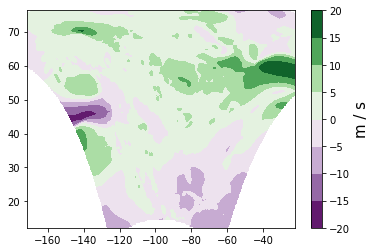

In [11]:
var = 'uas'
plt.contourf(hist.lon, hist.lat, hist[var].isel(time=0), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
cbar = plt.colorbar()
cbar.set_label('m / s', size=15)

In [12]:
rcp85

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 129, lon: 300, time: 34674)
Coordinates:
  * time       (time) object 2006-01-01 12:00:00 ... 2100-12-30 12:00:00
  * lat        (lat) float64 12.25 12.75 13.25 13.75 ... 74.75 75.25 75.75 76.25
  * lon        (lon) float64 -171.8 -171.2 -170.8 ... -23.25 -22.75 -22.25
    time_bnds  (time, bnds) object dask.array<shape=(34674, 2), chunksize=(100, 2)>
Dimensions without coordinates: bnds
Data variables:
    uas        (time, lat, lon) float32 dask.array<shape=(34674, 129, 300), chunksize=(100, 129, 300)>
Attributes:
    Conventions:                    CF-1.4
    institution:                    Universite du Quebec a Montreal
    contact:                        Winger.Katja@uqam.ca
    comment:                        CORDEX North America CRCM5 v333 0.44 deg ...
    model:                          CRCM5 (dynamics GEM v_3.3.3, physics RPN ...
    model_grid:                     rotated lat-lon 212x200 incl. 10p pilot a...
    geophysical_fiel

In [121]:
rcp85.uas.isel(time=16359)

<xarray.DataArray 'uas' (lat: 129, lon: 300)>
dask.array<shape=(129, 300), dtype=float32, chunksize=(129, 300)>
Coordinates:
    time     object 2050-10-27 12:00:00
  * lat      (lat) float64 12.25 12.75 13.25 13.75 ... 74.75 75.25 75.75 76.25
  * lon      (lon) float64 -171.8 -171.2 -170.8 -170.2 ... -23.25 -22.75 -22.25
Attributes:
    units:          m s-1
    long_name:      Eastward Near-Surface Wind
    standard_name:  eastward_wind
    level_desc:     Height
    grid_desc:      rotated_pole
    cell_methods:   time: mean
    remap:          remapped via ESMF_regrid_with_weights: Higher-order Patch

In [123]:
rcp85.uas.sel(time='2050-10-27')

<xarray.DataArray 'uas' (time: 1, lat: 129, lon: 300)>
dask.array<shape=(1, 129, 300), dtype=float32, chunksize=(1, 129, 300)>
Coordinates:
  * time     (time) object 2050-10-27 12:00:00
  * lat      (lat) float64 12.25 12.75 13.25 13.75 ... 74.75 75.25 75.75 76.25
  * lon      (lon) float64 -171.8 -171.2 -170.8 -170.2 ... -23.25 -22.75 -22.25
Attributes:
    units:          m s-1
    long_name:      Eastward Near-Surface Wind
    standard_name:  eastward_wind
    level_desc:     Height
    grid_desc:      rotated_pole
    cell_methods:   time: mean
    remap:          remapped via ESMF_regrid_with_weights: Higher-order Patch

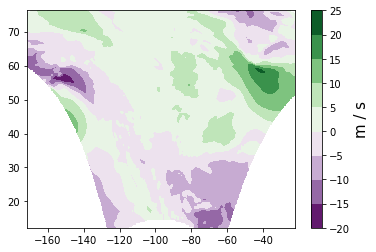

In [124]:
plt.contourf(rcp85.lon, rcp85.lat, rcp85[var].isel(time=16359), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
cbar = plt.colorbar()
cbar.set_label('m / s', size=15)

In [16]:
#Measured Data still not supported by intake-esm

path = '../../kddm/data/uas/'
measured = xr.open_dataset(path+'uas.METDATA.44i.nc', chunks = {'time':100})
#hist = xr.open_dataset(path+'uas.hist.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.nc', chunks = {'time':5})
#rcp85 = xr.open_dataset(path+'uas.rcp85.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.nc', chunks = {'time':5})

In [17]:
measured

<xarray.Dataset>
Dimensions:  (lat: 129, lon: 300, time: 12784)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T18:00:00 ... 2013-12-31T18:00:00
  * lat      (lat) float64 12.25 12.75 13.25 13.75 ... 74.75 75.25 75.75 76.25
  * lon      (lon) float64 188.2 188.8 189.2 189.8 ... 336.2 336.8 337.2 337.8
Data variables:
    uas      (time, lat, lon) float32 dask.array<shape=(12784, 129, 300), chunksize=(100, 129, 300)>
Attributes:
    author:                    John Abatzoglou - University of Idaho, jabatzo...
    creation_date:             18 May 2012
    datum:                     WGS 84
    title:                     METDATA gridded surface meteorological data
    institution:               University of Idaho
    contact:                   John Abatzoglou, jabatzoglou@uidaho.edu
    URL:                       http://metdata.northwestknowledge.net/
    references:                Abatzoglou, J.T., 2012, Development of gridded...
    source:                    METDATA combines

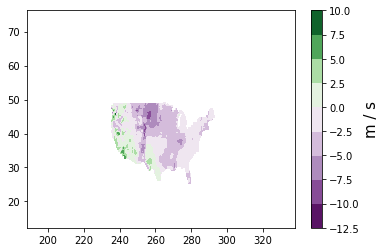

In [18]:
plt.contourf(measured.lon, measured.lat, measured[var].isel(time=0), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
cbar = plt.colorbar()
cbar.set_label('m / s', size=15)

## Filter and Regrid Data to Quarter Degree Grid

In [19]:
def _flt_nans(ds):
    ds_droplats = ds.dropna(dim='lat', how ='all')
    ds_flt = ds_droplats.dropna(dim='lon', how='all')
    return ds_flt

def _get_wesn(ds):
    lon_min = float(np.min(ds.lon))
    lon_max = float(np.max(ds.lon))
    lat_min = float(np.min(ds.lat))
    lat_max = float(np.max(ds.lat))
    wesn = [lon_min, lon_max, lat_min, lat_max]
    return wesn

def _get_newgrid(ds, wesn):
    grid = 0.25
    wesn_g = [int(round(i * 4)) / 4 for i in wesn]

    new_lon = np.arange(wesn_g[0],wesn_g[1], grid)
    new_lat = np.arange(wesn_g[2], wesn_g[3]+grid, grid)

    newgrid = xr.Dataset({'lat': (['lat'], new_lat), 'lon': (['lon'], new_lon)})
    return newgrid

def _force_pos_lon(ds):
    ds_poslon = ds.assign_coords(lon = ds.lon+ 360) if (np.min(ds.lon) < 0) else ds
    return ds_poslon

def _regrid(ds, newgrid, method='bilinear'):
    regridder_ds = xe.Regridder(ds, newgrid, method)
    ds_rgrd = regridder_ds(ds[var])
    return ds_rgrd

In [20]:
def regrid_measured_coords(ds, method='bilinear'):
    ds_flt = _flt_nans(ds)
    wesn = _get_wesn(ds_flt)
    newgrid = _get_newgrid(ds_flt, wesn)
    ds_rgrd = _regrid(ds_flt, newgrid, method)
    return ds_rgrd, wesn, newgrid

def regrid_model_coords(ds, wesn, newgrid):
    ds_poslon = _force_pos_lon(ds)    
    ds_flt = ds_poslon.sel(lon = slice(wesn[0], wesn[1]),lat = slice(wesn[2], wesn[3]))
    ds_rgrd = _regrid(ds_flt, newgrid)
    return ds_rgrd

In [21]:
measured_rgrd, wesn, newgrid = regrid_measured_coords(measured)
hist_rgrd = regrid_model_coords(hist, wesn, newgrid)
rcp85_rgrd = regrid_model_coords(rcp85, wesn, newgrid)

Overwrite existing file: bilinear_49x116_97x230.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_49x116_97x230.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_49x116_97x230.nc 
 You can set reuse_weights=True to save computing time.


In [22]:
measured_rgrd

<xarray.DataArray 'uas' (time: 12784, lat: 97, lon: 230)>
array([[[nan,  0., ..., nan,  0.],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan,  0., ..., nan,  0.],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan,  0., ..., nan,  0.],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan,  0., ..., nan,  0.],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * lon      (lon) float64 235.2 235.5 235.8 236.0 ... 291.8 292.0 292.2 292.5
  * lat      (lat) float64 25.25 25.5 25.75 26.0 26.25 ... 48.5 48.75 49.0 49.25
  * time     (time) datetime64[ns] 1979-01-01T18:00:00 ... 2013-12-31T18:00:00
Attributes:
    regrid_method:  bilinear

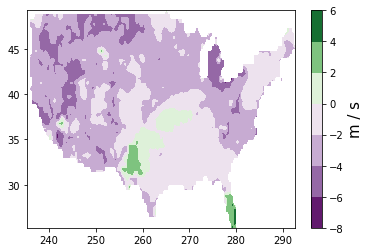

In [23]:
plt.contourf(measured_rgrd.lon, measured_rgrd.lat, measured_rgrd.isel(time=300), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
cbar = plt.colorbar()
cbar.set_label('m / s', size=15)

In [24]:
hist_rgrd

<xarray.DataArray 'uas' (time: 20440, lat: 97, lon: 230)>
array([[[-2.695749,  0.      , ..., -1.328027,  0.      ],
        [-2.520496, -2.559895, ..., -1.328161, -1.201493],
        ...,
        [-2.613294, -2.23724 , ...,  2.031433,  2.031059],
        [-1.36579 , -1.373427, ...,  2.222981,  2.415996]],

       [[-4.738876,  0.      , ..., -2.791428,  0.      ],
        [-4.597237, -4.609545, ..., -2.838502, -2.761654],
        ...,
        [-1.068268, -0.912631, ...,  3.238431,  3.184399],
        [-1.195681, -1.220764, ...,  3.250021,  3.365657]],

       ...,

       [[-2.386081,  0.      , ...,  8.028358,  0.      ],
        [-2.363914, -2.311048, ...,  8.474684,  8.470456],
        ...,
        [-1.363128, -1.356034, ..., -7.048817, -6.943714],
        [-1.346059, -1.540257, ..., -7.479018, -7.915758]],

       [[-3.129025,  0.      , ...,  0.630677,  0.      ],
        [-2.93675 , -2.793691, ...,  0.873429,  0.865999],
        ...,
        [ 1.871005,  1.764003, ...,  0.282991

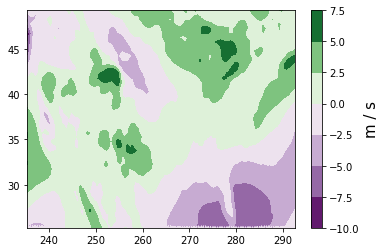

In [25]:
plt.contourf(hist_rgrd.lon, hist_rgrd.lat, hist_rgrd.isel(time=0), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
cbar = plt.colorbar()
cbar.set_label('m / s', size=15)

In [26]:
rcp85_rgrd

<xarray.DataArray 'uas' (time: 34674, lat: 97, lon: 230)>
array([[[-4.565626,  0.      , ...,  2.124518,  0.      ],
        [-4.341277, -4.131176, ...,  2.459693,  2.436744],
        ...,
        [ 0.277411,  0.483086, ...,  1.980614,  1.824785],
        [ 0.307784,  0.530772, ...,  1.922985,  1.809547]],

       [[-5.543156,  0.      , ..., -3.226155,  0.      ],
        [-5.372837, -5.190542, ..., -2.984439, -2.76816 ],
        ...,
        [-2.237809, -2.135275, ...,  7.711422,  7.662871],
        [-1.819258, -2.01786 , ...,  7.585784,  7.999334]],

       ...,

       [[ 0.573676,  0.      , ...,  5.086287,  0.      ],
        [ 0.6608  ,  0.405164, ...,  5.519511,  5.218391],
        ...,
        [-2.221761, -2.035392, ..., -7.337241, -7.218599],
        [-1.486024, -1.569708, ..., -7.762578, -8.163323]],

       [[ 0.096178,  0.      , ...,  1.829699,  0.      ],
        [ 0.171771,  0.276366, ...,  2.24282 ,  2.277234],
        ...,
        [-1.953026, -1.77832 , ..., -3.137006

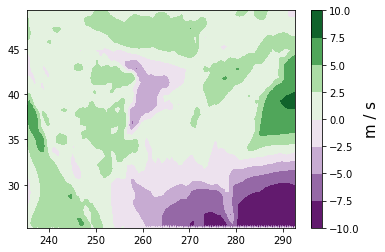

In [27]:
plt.contourf(rcp85_rgrd.lon, rcp85_rgrd.lat, rcp85_rgrd.isel(time=16211), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
cbar = plt.colorbar()
cbar.set_label('m / s', size=15)

## Align Time

Things to be added to this section:
- Utilize calendar checking. Does this break if the calendars are different from Datetime.NoLeap and Gregorian?
- Add different methods of forcing a 366 day calendar to match the 365 day calendar - or a 360 day calendar for that matter:
     - Interpolation is not good for discontinuous atmospheric variables
     - Perhaps only average February 28th and 29th together (as opposed to the whole dataset being affected)
     - Try subsampling (always drop February 29th or December 31st vs randomly distributing dropped days so they don't fall in the same place each year
- Add an alert so for spiky discontinuous variables letting the user know how much precipitation was dropped, ex

In [28]:
def _check_calendars(da_measured, da_hist, da_rcp):
    cal_measured = da_measured.time.encoding['calendar']
    cal_hist = da_hist.time.encoding['calendar']
    cal_fut = da_rcp.time.encoding['calendar']
    return cal_measured, cal_hist, cal_fut

def _cfnoleap_to_datetime(da):
    datetimeindex = da.indexes['time'].to_datetimeindex()
    ds = da.to_dataset()
    ds['time_dt']= ('time', datetimeindex)
    ds = ds.swap_dims({'time': 'time_dt'})
    assert len(da.time) == len(ds.time_dt)
    return ds

def _regroup_models_bytime(da_measured, ds_hist, ds_rcp):
    t0_measured = da_measured.time[0]
    t_last_measured = da_measured.time[-1]
    t0_fut = t_last_measured.values + np.timedelta64(1, 'D')
    
    ds_past = ds_hist.sel(time_dt = slice(t0_measured, t_last_measured))
    
    ds_fut_pt1 = ds_hist.sel(time_dt = slice(t0_fut,None))
    ds_fut = xr.concat([ds_fut_pt1, ds_rcp], 'time_dt')
    return ds_past, ds_fut

def _cal_interpolate(da_measured, ds_past):
    years = da_measured.time.dt.year
    leap_bool = [isleap(y) for y in set(years.values)]

    da_measured_noleap = da_measured.interp(time = ds_past.time_dt)
    da_measured_noleap.coords['time'] = ds_past.time
    assert len(da_measured_noleap.time) - len(ds_past.time_dt) == 0
    return da_measured_noleap

In [29]:
def align_time(da_measured, da_hist, da_rcp, method='interpolate'):
    ds_hist_dt = _cfnoleap_to_datetime(da_hist) 
    ds_rcp_dt = _cfnoleap_to_datetime(da_rcp)  
    
    ds_past, ds_fut = _regroup_models_bytime(da_measured, ds_hist_dt, ds_rcp_dt)
    
    if method == 'interpolate':
        ds_measured_noleap = _cal_interpolate(da_measured, ds_past)
    else:
        raise ValueError('Only Interpolation Method is Supported.')
    
    ds_measured = ds_measured_noleap.swap_dims({'time_dt':'time'})
    ds_past = ds_past.swap_dims({'time_dt':'time'})
    ds_fut = ds_fut.swap_dims({'time_dt':'time'})
    return ds_measured, ds_past, ds_fut

In [30]:
ds_measured, ds_past, ds_fut = align_time(measured_rgrd, hist_rgrd, rcp85_rgrd)

/glade/u/home/jkent/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  


In [31]:
ds_measured

<xarray.DataArray 'uas' (time: 9854, lat: 97, lon: 230)>
array([[[nan,  0., ..., nan,  0.],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan,  0., ..., nan,  0.],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan,  0., ..., nan,  0.],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan,  0., ..., nan,  0.],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * lon      (lon) float64 235.2 235.5 235.8 236.0 ... 291.8 292.0 292.2 292.5
  * lat      (lat) float64 25.25 25.5 25.75 26.0 26.25 ... 48.5 48.75 49.0 49.25
  * time     (time) object 1979-01-02 12:00:00 ... 2005-12-31 12:00:00
    time_dt  (time) datetime64[ns] 1979-01-02T12:00:00 ... 2005-12

In [32]:
ds_past

<xarray.Dataset>
Dimensions:  (lat: 97, lon: 230, time: 9854)
Coordinates:
  * lon      (lon) float64 235.2 235.5 235.8 236.0 ... 291.8 292.0 292.2 292.5
  * lat      (lat) float64 25.25 25.5 25.75 26.0 26.25 ... 48.5 48.75 49.0 49.25
  * time     (time) object 1979-01-02 12:00:00 ... 2005-12-31 12:00:00
    time_dt  (time) datetime64[ns] 1979-01-02T12:00:00 ... 2005-12-31T12:00:00
Data variables:
    uas      (time, lat, lon) float64 -5.603 0.0 -5.309 ... 0.1188 -0.08994

In [33]:
ds_fut

<xarray.Dataset>
Dimensions:  (lat: 97, lon: 230, time: 34674)
Coordinates:
  * lon      (lon) float64 235.2 235.5 235.8 236.0 ... 291.8 292.0 292.2 292.5
  * lat      (lat) float64 25.25 25.5 25.75 26.0 26.25 ... 48.5 48.75 49.0 49.25
  * time     (time) object 2006-01-01 12:00:00 ... 2100-12-30 12:00:00
    time_dt  (time) datetime64[ns] 2006-01-01T12:00:00 ... 2100-12-30T12:00:00
Data variables:
    uas      (time, lat, lon) float64 -4.566 0.0 -4.153 ... -3.257 -3.692 -4.064

## Bias Correction
### Need to Grouby Average for Every Day Across Years
#### (Dec 15 -> full 12 months -> Jan 15)

Things to be added to this section:   
- Bias correction methods other than zscore:
    - scale (for wind speed, wave flux in air)
    - log (for precipitation)
    - range (relative humidity)
    - seth mcginnes's kddm (for any bimodal distributions)
- Option for time notto be flattened to a one year array for analysis (for temperature with strong climate change trend)
- If data cannot be bias-corrected it should be filled with uncorrected data, currently it becomes NaNs

In [34]:
def _hack_circular_rolling(ds):
    ds_avyear = ds.groupby('time.dayofyear').mean(dim='time')
    
    last = ds_avyear.isel(dayofyear=slice(-15, None))
    last['dayofyear'] = np.arange(-15,0)
    
    first = ds_avyear.isel(dayofyear=slice(0, 15))
    first['dayofyear'] = np.arange(366,381)
    
    ds_circ = xr.concat([last, ds_avyear, first], 'dayofyear')
    return ds_avyear, ds_circ;

def _calc_circ_stats(ds_avyear, ds_circ, window_width): 
    ds_mean = ds_circ.rolling(dayofyear=window_width, center=True).mean()
    ds_circ_mean = ds_mean.sel(dayofyear = slice(1, 365))

    ds_std = ds_circ.rolling(dayofyear=window_width, center=True).std()
    ds_circ_std = ds_std.sel(dayofyear = slice(1, 365))

    ds_circ_zscore = (ds_avyear - ds_mean) / ds_std
    return ds_circ_mean, ds_circ_std, ds_circ_zscore;

def _get_circ_stats(ds, window_width):
    ds_av, ds_circ = _hack_circular_rolling(ds)
    ds_circ_mean, ds_circ_std, ds_circ_zscore = _calc_circ_stats(ds_av, ds_circ, window_width)
    return ds_circ_mean, ds_circ_std, ds_circ_zscore

In [88]:
def _get_bc_params(measured_circ_mean, measured_circ_std, past_circ_mean, past_circ_std):    
    shift = measured_circ_mean - past_circ_mean
    scale = measured_circ_std / past_circ_std
    return shift, scale

def _get_bc_circ_stats(circ_mean, circ_std, shift, scale):
    circ_mean_bc = circ_mean + shift
    circ_std_bc = circ_std * scale
    return circ_mean_bc, circ_std_bc

def _expand_bc_stats(ds,circ_mean_bc, circ_std_bc):
    means_bc=[]
    stds_bc = []
    for doy in ds['time.dayofyear']:
        means_bc.append(circ_mean_bc.sel(dayofyear=doy))
        stds_bc.append(circ_std_bc.sel(dayofyear=doy))

    mean_bc = xr.concat(means_bc,dim='time')
    std_bc = xr.concat(stds_bc,dim='time')
    return mean_bc, std_bc

def _get_stats (ds, window_width):
    ds_mean = ds.rolling(time=window_width, center=True).mean()
    ds_std = ds.rolling(time=window_width, center=True).std()
    ds_zscore = (ds - ds_mean) / ds_std
    return ds_zscore

In [89]:
def _z_score_correction(ds_measured, ds_past, ds_fut, window_width):
    measured_circ_mean, measured_circ_std, measured_circ_zscore = _get_circ_stats(ds_measured, window_width)
    past_circ_mean, past_circ_std, past_circ_zscore = _get_circ_stats(ds_past, window_width)
    fut_circ_mean, fut_circ_std, fut_circ_zscore = _get_circ_stats(ds_fut, window_width)
    
    shift, scale = _get_bc_params(measured_circ_mean, measured_circ_std, past_circ_mean, past_circ_std)
    
    past_circ_mean_bc, past_circ_std_bc = _get_bc_circ_stats(past_circ_mean, past_circ_std, shift, scale)
    fut_circ_mean_bc, fut_circ_std_bc = _get_bc_circ_stats(fut_circ_mean, fut_circ_std, shift, scale)
    
    past_mean_bc, past_std_bc = _expand_bc_stats(ds_past,past_circ_mean_bc, past_circ_std_bc)
    fut_mean_bc, fut_std_bc = _expand_bc_stats(ds_fut,fut_circ_mean_bc, fut_circ_std_bc)
    
    past_zscore = _get_stats(ds_past, window_width)
    fut_zscore = _get_stats(ds_fut, window_width)
    
    past_corrected = (past_zscore * past_std_bc) + past_mean_bc
    fut_corrected = (fut_zscore * fut_std_bc) + fut_mean_bc
    return past_corrected, fut_corrected

In [92]:
def gaus(circ_mean, circ_std, doy):
    a = circ_mean.sel(dayofyear=doy)
    mu = a.isel(lon = 55, lat = 45)

    b = circ_std.sel(dayofyear=152)
    sigma = b.isel(lon = 55, lat = 45)

    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = stats.norm.pdf(x, mu, sigma)
    return x, y

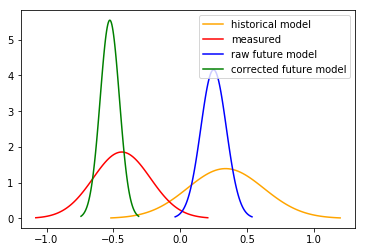

In [107]:
doy=20
plt.figure()
x,y = gaus(past_circ_mean[var], past_circ_std[var], doy)
plt.plot(x, y, 'orange', label = 'historical model')
x,y = gaus(measured_circ_mean, measured_circ_std, doy)
plt.plot(x, y, 'red', label = 'measured')
x,y = gaus(fut_circ_mean[var], fut_circ_std[var], doy)
plt.plot(x, y, 'blue', label = 'raw future model')
x,y = gaus(fut_circ_mean_bc[var], fut_circ_std_bc[var], doy)
plt.plot(x, y, 'green', label = 'corrected future model')
plt.legend()

In [108]:
def bias_correct(ds_measured, ds_past, ds_fut, method='z_score', window_width=31):
    if method == 'z_score':
        past_corrected, fut_corrected = _z_score_correction(ds_measured, ds_past, ds_fut, window_width)
    else:
        raise ValueError('Only Z-Score Bias Correction is Supported')
    return past_corrected, fut_corrected

In [109]:
past_corrected, fut_corrected = bias_correct(ds_measured, ds_past, ds_fut)

/glade/u/home/jkent/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [110]:
past_corrected

<xarray.Dataset>
Dimensions:    (lat: 97, lon: 230, time: 9854)
Coordinates:
  * lon        (lon) float64 235.2 235.5 235.8 236.0 ... 291.8 292.0 292.2 292.5
  * lat        (lat) float64 25.25 25.5 25.75 26.0 ... 48.5 48.75 49.0 49.25
  * time       (time) object 1979-01-02 12:00:00 ... 2005-12-31 12:00:00
    time_dt    (time) datetime64[ns] 1979-01-02T12:00:00 ... 2005-12-31T12:00:00
    dayofyear  (time) int64 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
Data variables:
    uas        (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

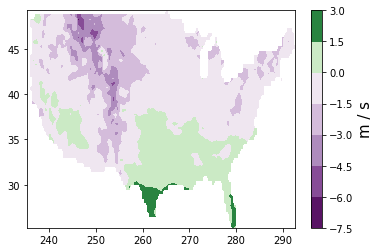

In [111]:
plt.contourf(past_corrected[var].lon, past_corrected[var].lat, past_corrected[var].isel(time=299), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
cbar = plt.colorbar()
cbar.set_label('m / s', size=15)

In [115]:
fut_corrected.isel(time = 16359)

<xarray.Dataset>
Dimensions:    (lat: 97, lon: 230)
Coordinates:
  * lon        (lon) float64 235.2 235.5 235.8 236.0 ... 291.8 292.0 292.2 292.5
  * lat        (lat) float64 25.25 25.5 25.75 26.0 ... 48.5 48.75 49.0 49.25
    time       object 2050-10-27 12:00:00
    time_dt    datetime64[ns] 2050-10-27T12:00:00
    dayofyear  int64 300
Data variables:
    uas        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

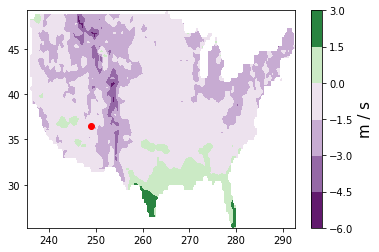

In [128]:
plt.contourf(fut_corrected[var].lon, fut_corrected[var].lat, fut_corrected[var].isel(time=16359), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
cbar = plt.colorbar()
cbar.set_label('m / s', size=15)
plt.scatter(249,36.5,c='r')

In [119]:
diff = ds_fut[var].isel(time=16359) - fut_corrected[var].isel(time=16359)

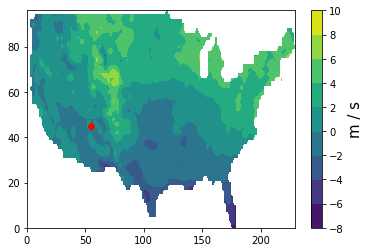

In [133]:
plt.contourf(diff)
cbar = plt.colorbar()
cbar.set_label('m / s', size=15)
plt.scatter(55,45,c='r')